# Clustering 
1. Hierarchical clustering
2. K-means clustering
3. DBScanner clustering

#### Importing necessary libraries

In [64]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth #
from sklearn.neighbors import NearestNeighbors #
from sklearn.mixture import GaussianMixture #
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns 


### Hierarchical clustering  SÓ TESTE :) 

#### Load dataset and use .head() to view the first 6 rows of the dataset

In [2]:
df = pd.read_csv('Processed_Data.csv')
print(df.head(6))

  customer_id  customer_region  customer_age  vendor_count  product_count  \
0  1b8f824d5e             2360          18.0           2.0            5.0   
1  5d272b9dcb             8670          17.0           2.0            2.0   
2  f6d1b2ba63             4660          38.0           1.0            2.0   
3  180c632ed8             4660          24.0           2.0            3.0   
4  4eb37a6705             4660          20.0           2.0            5.0   
5  6aef2b6726             8670          40.0           2.0            2.0   

   is_chain  first_order  last_order last_promo payment_method  ...  \
0       1.0          0.0         1.0   DELIVERY           DIGI  ...   
1       2.0          0.0         1.0   DISCOUNT           DIGI  ...   
2       2.0          0.0         1.0   DISCOUNT           CASH  ...   
3       1.0          0.0         2.0   DELIVERY           DIGI  ...   
4       0.0          0.0         2.0   No promo           DIGI  ...   
5       0.0          0.0         2

#### Separate numerical and categorical features
To handle mixed data types we have to seperate numerical and categorical features

In [3]:
numerical_features = [
    'customer_age', 'vendor_count', 'product_count',
] + [f'DOW_{i}' for i in range(7)] + [f'HR_{i}' for i in range(24)] + \
[col for col in df.columns if col.startswith('CUI_')]

categorical_features = ['customer_region', 'is_chain']

print(f"Numerical Features: {numerical_features}")
print(f"Categorical Features: {categorical_features}")

Numerical Features: ['customer_age', 'vendor_count', 'product_count', 'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe', 'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes', 'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai']
Categorical Features: ['customer_region', 'is_chain']


Handeling possible mussing values

In [4]:
# Fill missing values for numerical features with the mean
df[numerical_features] = df[numerical_features].fillna(df[numerical_features].mean())

# Fill missing values for categorical features with the mode
for feature in categorical_features:
    df[feature] = df[feature].fillna(df[feature].mode()[0])


### Preprocess Data

##### Numerical varibles

1. Scale numerical features using StandardScaler
2. Encoding categorical features using One-Hot Encoding

In [5]:
1. 
scaler = StandardScaler()
data_scaled_numerical = scaler.fit_transform(df[numerical_features])

# Convert back to a DataFrame for easier handling
data_scaled_numerical = pd.DataFrame(data_scaled_numerical, columns=numerical_features)

In [6]:
2. 
data_encoded_categorical = pd.get_dummies(df[categorical_features], drop_first=True)

# Check the transformed categorical data
print("One-Hot Encoded Categorical Features:")
print(data_encoded_categorical.head())

One-Hot Encoded Categorical Features:
   customer_region  is_chain
0             2360       1.0
1             8670       2.0
2             4660       2.0
3             4660       1.0
4             4660       0.0


#### Combine processed data: numerical and categorical

In [7]:
# Combine numerical and categorical data
data_preprocessed = pd.concat([data_scaled_numerical, data_encoded_categorical], axis=1)

# Confirm the shape of the processed data
print(f"Preprocessed Data Shape: {data_preprocessed.shape}")


Preprocessed Data Shape: (31875, 51)


## Linkage Matrix

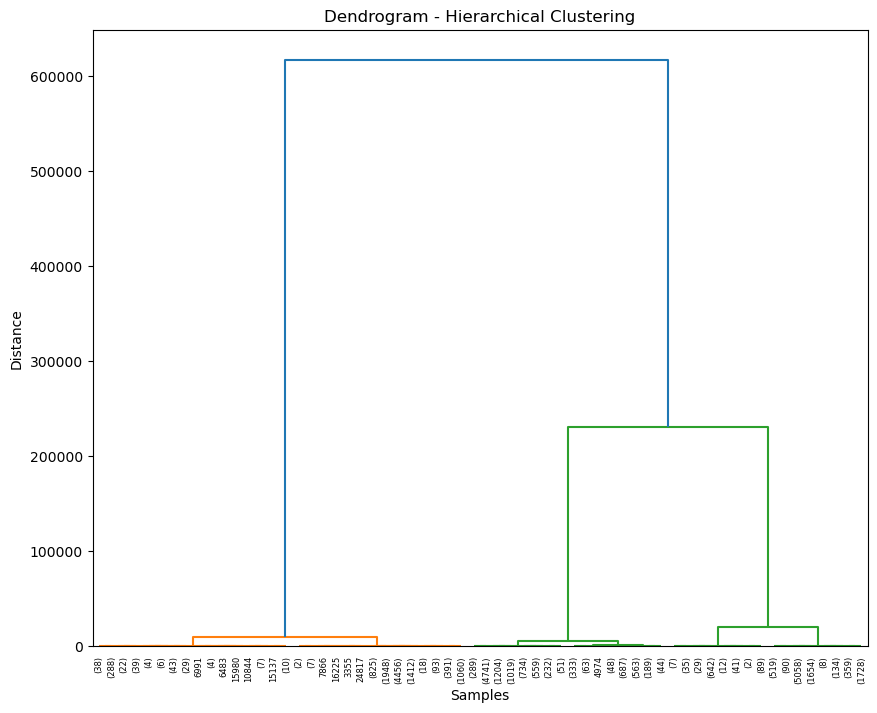

In [8]:
# Build the linkage matrix using Euclidean distance
linkage_matrix = linkage(data_preprocessed, method='ward')

# Visualize the dendrogram
plt.figure(figsize=(10, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)  # Show the top 5 levels
plt.title("Dendrogram - Hierarchical Clustering")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()


### Observations from the Dendrogram

1. **Number of Clusters**:
   - There is a significant jump at the 600,000 distance mark, suggesting that **2 main clusters** could be formed.
   - If more granularity is needed, cutting at a lower distance (e.g., 200,000) could result in **4 smaller clusters**.

2. **Cluster Compactness**:
   - The smaller branches at the bottom of the dendrogram indicate **tight, similar groups** within clusters.
   - The larger distances between the green and orange branches show **clear separation** between the two main clusters.

3. **Hierarchical Relationships**:
   - The hierarchy reveals **subgroups within each main cluster**, which could be further explored if additional detail is required.

### Conclusion
- Start with **2 clusters** for broader analysis.
- Explore **4 clusters** for more detailed segmentation if necessary.


#### Decide the number oof clusters based on the dendrogram above

In [9]:
# Decide the number of clusters (e.g., 4)
num_clusters = 4

# Generate cluster labels
clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

# Add cluster labels to the original dataset
df['cluster'] = clusters


### analyze clusters

In [10]:
# Analyze numerical features by cluster
cluster_profiles_numerical = df.groupby('cluster')[numerical_features].mean()

print("Cluster Profiles - Numerical Features:")
print(cluster_profiles_numerical)


Cluster Profiles - Numerical Features:
         customer_age  vendor_count  product_count     DOW_0     DOW_1  \
cluster                                                                  
1           27.451685      2.861451       4.797466  0.485482  0.481468   
2           27.424468      3.595705       6.304055  0.658641  0.676118   
3           27.649942      1.803967       4.144131  0.347725  0.355893   
4           27.462513      2.811728       5.589742  0.537906  0.560838   

            DOW_2     DOW_3     DOW_4     DOW_5     DOW_6  ...  CUI_Chinese  \
cluster                                                    ...                
1        0.491551  0.490430  0.487816  0.518252  0.539632  ...     1.142122   
2        0.695082  0.718323  0.766385  0.765362  0.847355  ...     2.593849   
3        0.415403  0.423571  0.596266  0.480747  0.581097  ...     0.217316   
4        0.600838  0.670157  0.798639  0.692880  0.739267  ...     0.556768   

         CUI_Desserts  CUI_Healthy  CUI_I

In [11]:
# Analyze categorical features by cluster
categorical_cluster_profiles = {}
for feature in categorical_features:
    proportions = df.groupby('cluster')[feature].value_counts(normalize=True).unstack()
    categorical_cluster_profiles[feature] = proportions

# Display cluster profiles for categorical features
for feature, profile in categorical_cluster_profiles.items():
    print(f"\nCluster Profiles for Categorical Feature: {feature}")
    print(profile)



Cluster Profiles for Categorical Feature: customer_region
customer_region      2360      2440      2490  4140  4660      8370      8550  \
cluster                                                                         
1                     NaN       NaN       NaN   NaN   NaN  0.046214  0.001214   
2                0.820768  0.137864  0.041368   NaN   NaN       NaN       NaN   
3                     NaN       NaN       NaN   1.0   NaN       NaN       NaN   
4                     NaN       NaN       NaN   NaN   1.0       NaN       NaN   

customer_region      8670  
cluster                    
1                0.952572  
2                     NaN  
3                     NaN  
4                     NaN  

Cluster Profiles for Categorical Feature: is_chain
is_chain      0.0       1.0       2.0       3.0       4.0       5.0   \
cluster                                                                
1         0.236953  0.332275  0.195407  0.105312  0.050509  0.028475   
2         0.039509

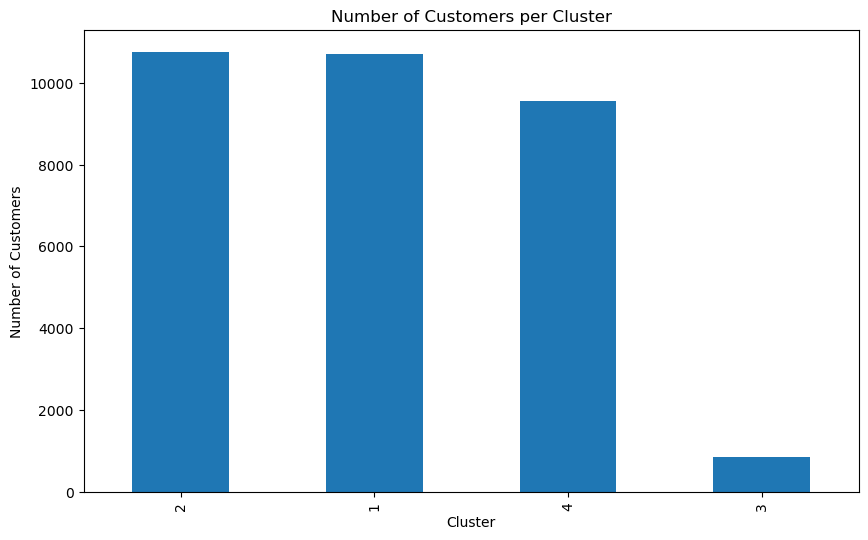

In [12]:
# Distribution of customers across clusters
df['cluster'].value_counts().plot(kind='bar', figsize=(10, 6))
plt.title("Number of Customers per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.show()


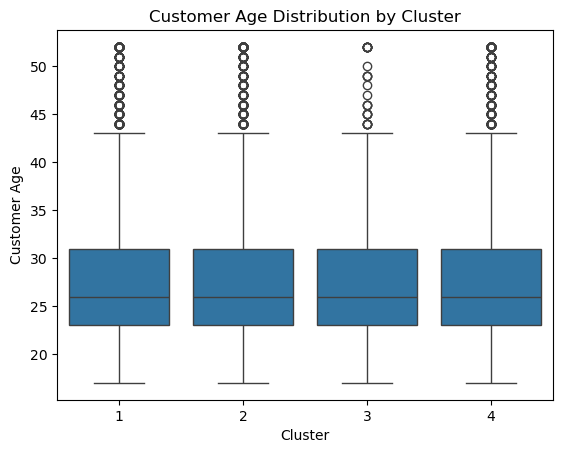

In [13]:
# Boxplot for customer age by cluster
sns.boxplot(x='cluster', y='customer_age', data=df)
plt.title("Customer Age Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Customer Age")
plt.show()


### 3. DBSCAN (Density-based spatial clustering of applications with noise)
### Testeeeeeee

In [19]:
# Splitting feature names into groups
# Remember which metric_features we decided to keep?
metric_features = df.select_dtypes(include=['number']).columns.tolist()

# Identify non-metric (categorical) features
non_metric_features = df.select_dtypes(exclude=['number']).columns.tolist()
pc_features = df.columns[df.columns.str.startswith('PC')].tolist()  

unused_features = [i for i in df.columns if i not in (metric_features+non_metric_features+pc_features) ]

In [20]:
print('metric_features:', metric_features)
print('\nnon_metric_features:', non_metric_features)
print('\nunused_features:', unused_features)
print('\npc_features:', pc_features)

metric_features: ['customer_region', 'customer_age', 'vendor_count', 'product_count', 'is_chain', 'first_order', 'last_order', 'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe', 'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes', 'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'customer_city', 'engagement_duration', 'avg_order_frequency', 'tot_value_cui', 'preferred_order_day', 'preferred_order_hour', 'age_category', 'PC0', 'PC1', 'PC2', 'cluster']

non_metric_features: ['customer_id', 'last_promo', 'payment_method', 'chain_category']

unused_features: []

pc_features: ['PC0', 'PC1', 'PC2']


In [38]:
# Display only columns with missing values
missing_values_all = df.isnull().sum()
missing_values = missing_values_all[missing_values_all > 0]

# Display the columns with missing values
print(missing_values)

avg_order_frequency    156
dtype: int64


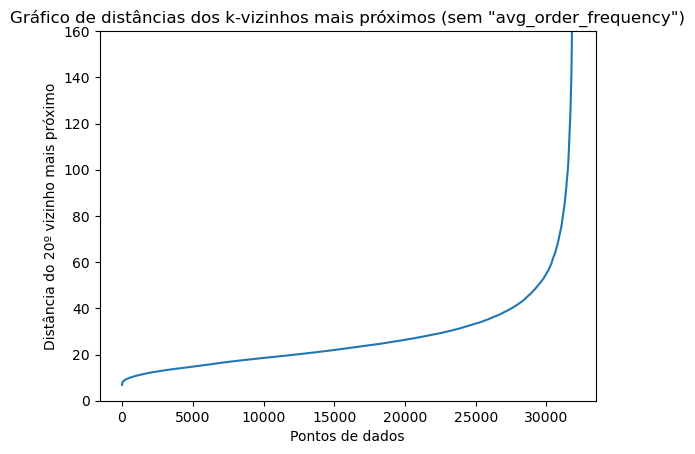

In [73]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Excluir a feature "avg_order_frequency" das metric features
features_for_distance = [feature for feature in metric_features if feature != "avg_order_frequency"]

# Calcular as distâncias dos k-vizinhos mais próximos
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df[features_for_distance])
distances, _ = neigh.kneighbors(df[features_for_distance])

# Ordenar as distâncias
distances = np.sort(distances[:, -1])

# Plotar o gráfico das distâncias
plt.plot(distances)
plt.xlabel('Pontos de dados')
plt.ylabel('Distância do 20º vizinho mais próximo')
plt.title('Gráfico de distâncias dos k-vizinhos mais próximos (sem "avg_order_frequency")')

# Alterar os limites do eixo y para 0 a 160
plt.ylim(0, 160)

plt.show()


In [60]:
# Concatenating the labels to df
df_concat = pd.concat([df[metric_features], pd.Series(dbscan_labels, index=df.index, name="dbscan_labels")], axis=1)
df_concat.head()

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,CUI_American,CUI_Asian,CUI_Beverages,...,avg_order_frequency,tot_value_cui,preferred_order_day,preferred_order_hour,age_category,PC0,PC1,PC2,cluster,dbscan_labels
0,2360,18.0,2.0,5.0,1.0,0.0,1.0,0.00,0.00,0.0,...,5.0,28.88,0,18,26,-33.588384,4.856703,68.805226,2,-1
1,8670,17.0,2.0,2.0,2.0,0.0,1.0,12.82,6.39,0.0,...,2.0,19.21,0,10,16,-38.805109,4.031286,68.700410,1,-1
2,4660,38.0,1.0,2.0,2.0,0.0,1.0,9.20,0.00,0.0,...,2.0,9.20,0,9,42,-48.358974,-2.407889,66.664748,4,-1
3,4660,24.0,2.0,3.0,1.0,0.0,2.0,0.00,13.70,0.0,...,1.5,31.56,1,11,26,-27.515592,10.829337,69.861756,4,-1
4,4660,20.0,2.0,5.0,0.0,0.0,2.0,14.57,40.87,0.0,...,2.5,55.44,1,8,26,-1.098321,31.390525,76.060649,4,-1


In [88]:
# Excluir a feature "total_value_cui" ao selecionar as features para o clustering
features_for_clustering = [feature for feature in metric_features if feature != "avg_order_frequency"]

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=40, min_samples=25, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df[features_for_clustering])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

#usei o eps=40 por causa do grafico
#usei min_samples=25 porque deve ser 2xdim e deve ser mais ou menos isso


Number of estimated clusters : 8


In [89]:
np.unique(dbscan_labels)


array([-1,  0,  1,  2,  3,  4,  5,  6])